In [5]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


In [6]:
reviews = pd.read_csv('C:\Ajinkya\Studies\ADS\Project\Reviews.csv')

In [7]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
con = sqlite3.connect('C:\Ajinkya\Studies\ADS\Project\database.sqlite')

pd.read_sql_query("SELECT * FROM Reviews LIMIT 3", con)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
messages = pd.read_sql_query("""
SELECT 
  Score, 
  Summary,
  Text,
  HelpfulnessNumerator as VotesHelpful, 
  HelpfulnessDenominator as VotesTotal
FROM Reviews 
WHERE Score != 3""", con)

In [10]:
#Lets see how we got the data
messages.head()

,Score,Summary,Text,VotesHelpful,VotesTotal
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,1
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,1,1
3,2,Cough Medicine,If you are looking for the secret ingredient i...,3,3
4,5,Great taffy,Great taffy at a great price. There was a wid...,0,0


In [11]:
messages["Sentiment"] = messages["Score"].apply(lambda score: "positive" if score > 3 else "negative")
messages["Usefulness"] = (messages["VotesHelpful"]/messages["VotesTotal"]).apply(lambda n: "useful" if n > 0.8 else "useless")

messages.head(5)

,Score,Summary,Text,VotesHelpful,VotesTotal,Sentiment,Usefulness
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,1,positive,useful
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0,negative,useless
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,1,1,positive,useful
3,2,Cough Medicine,If you are looking for the secret ingredient i...,3,3,negative,useful
4,5,Great taffy,Great taffy at a great price. There was a wid...,0,0,positive,useless


In [12]:
#Data for products whose rating is 5
messages[messages.Score == 5].head(10)

,Score,Summary,Text,VotesHelpful,VotesTotal,Sentiment,Usefulness
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,1,positive,useful
4,5,Great taffy,Great taffy at a great price. There was a wid...,0,0,positive,useless
6,5,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,0,0,positive,useless
7,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,0,0,positive,useless
8,5,Yay Barley,Right now I'm mostly just sprouting this so my...,1,1,positive,useful
9,5,Healthy Dog Food,This is a very healthy dog food. Good for thei...,0,0,positive,useless
10,5,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1,1,positive,useful
11,5,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,4,4,positive,useful
14,5,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,4,5,positive,useless
15,5,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...,4,5,positive,useless


In [13]:
#Data for products whose rating is 1
messages[messages.Score == 1].head(10)

,Score,Summary,Text,VotesHelpful,VotesTotal,Sentiment,Usefulness
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0,negative,useless
12,1,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,1,1,negative,useful
26,1,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0,1,negative,useless
47,1,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",0,7,negative,useless
57,1,stale product.,Arrived in 6 days and were so stale i could no...,2,2,negative,useful
67,1,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...,0,1,negative,useless
69,1,No Tea Flavor,No tea flavor at all. Just whole brunch of art...,0,0,negative,useless
90,1,Bad,I fed this to my Golden Retriever and he hated...,0,1,negative,useless
140,1,Rip off Price,These singles sell for $2.50 - $3.36 at the st...,1,1,negative,useful
150,1,Tasteless but low calorie,Seriously this product was as tasteless as the...,0,4,negative,useless


In [14]:
#As Scikit cannot work with the words, we need to assign a new dimension to each word and work with the word counts

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
import nltk

cleanupdata = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanupdata.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

messages["Summary_Clean"] = messages["Summary"].apply(cleanup)

train, test = train_test_split(messages, test_size=0.3)
print("%d --> Training data, %d --> Test data" % (len(train), len(test)))

368069 --> Training data, 157745 --> Test data


In [15]:
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [16]:
from wordcloud import WordCloud, STOPWORDS

# To cleanup stop words, add stop_words = STOPWORDS
# But it seems to function better without it
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(train["Summary_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Sentiment"]
y_test = test["Sentiment"]

prediction = dict()

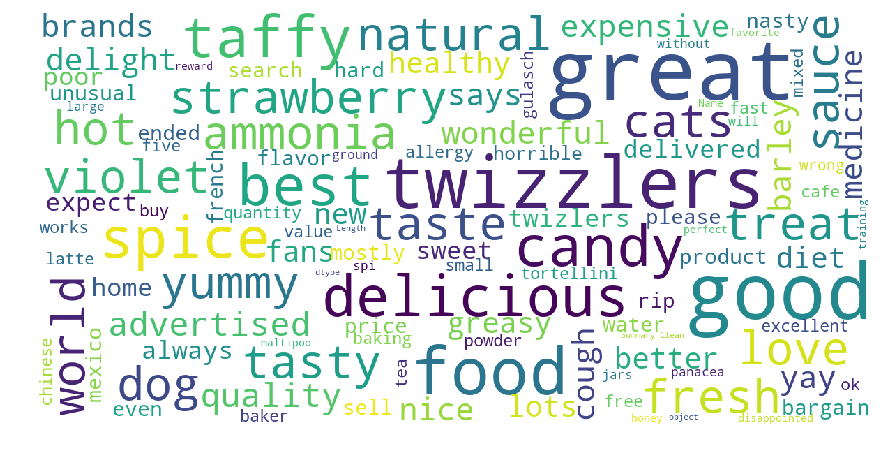

In [17]:
#Wordcloud depicting both positive as well as negative reviews
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary_Clean"])

# 

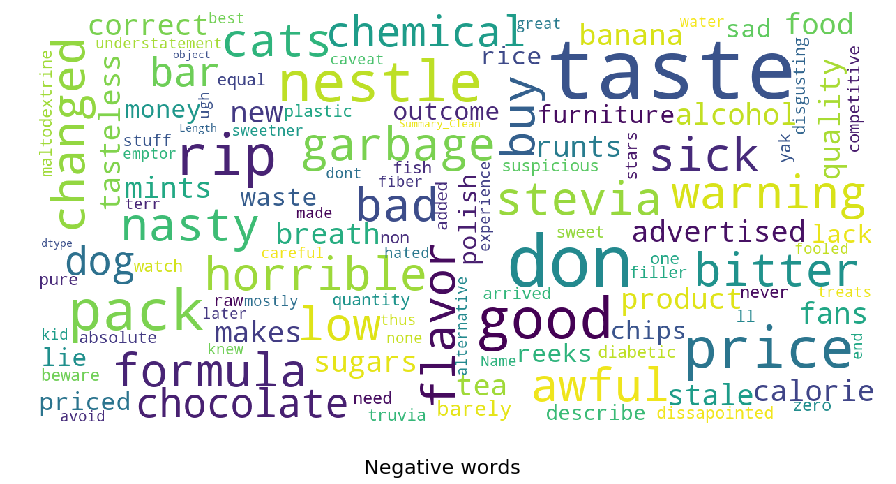

In [18]:
#Negative words which impacted the rating of the food items
show_wordcloud(messages[messages.Score == 1]["Summary_Clean"], title = "Negative words")

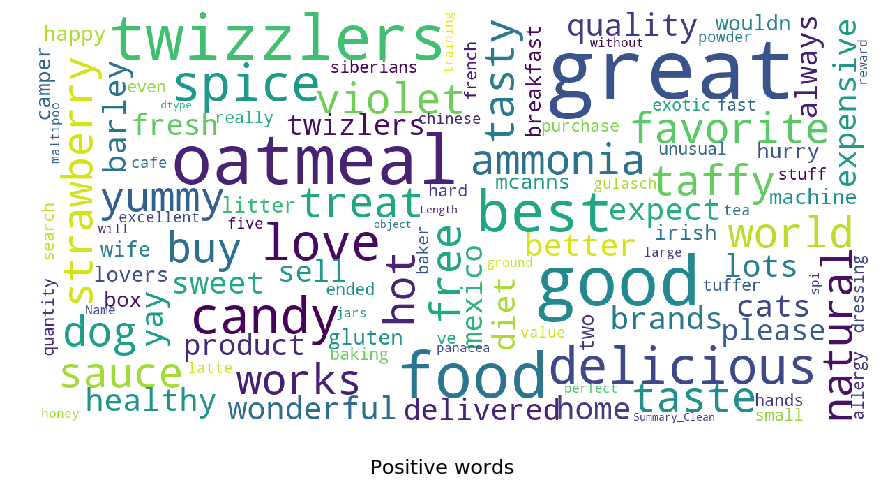

In [19]:
#Positive words which impacted the rating of the food items
show_wordcloud(messages[messages.Score == 5]["Summary_Clean"], title = "Positive words")

In [26]:
df = reviews[reviews['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# Features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('Number of train records: {}'.format(X_train.shape[0]))
    print('Number of test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('--- Top 20 positive words ---')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('--- Top 20 negative words ---')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# Features: 114969
Number of train records: 394360
Number of test records: 131454
Model Accuracy: 0.9387314193558203

--- Top 20 positive words ---
Coefficient           Word
   3.327643     pleasantly
   3.189435  emeraldforest
   3.001346        chedder
   2.559193        easiest
   2.447070        solving
   2.433008        blowout
   2.370716      addicting
   2.368502       heartier
   2.292219     unwrapping
   2.291049       drawback
   2.289582         hooked
   2.288130          herrs
   2.266416         skewed
   2.259576         hahaha
   2.249479       downside
   2.231996     correction
   2.187727          whisk
   2.184127         ration
   2.181312         bertie
   2.165358     dishwasher

--- Top 20 negative words ---
Coefficient           Word
  -2.465001         ripoff
  -2.489595       tastless
  -2.592699        weakest
  -2.599600      overrated
  -2.691895      cancelled
  -2.729232    unappealing
  -2.737504        furious
  -2.751046     oversalted
  -2.821837

In [28]:
#Accuracy is around 93%. However there are some insignificant words too which are of no use
#aseline accuracy

from sklearn.dummy import DummyClassifier
text_fit(X, y, c, DummyClassifier(),0)

# Features: 114969
Number of train records: 394360
Number of test records: 131454
Model Accuracy: 0.7363640513031174


In [29]:
#Logistic Regression model on TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# Features: 114969
Number of train records: 394360
Number of test records: 131454
Model Accuracy: 0.9346995907313584

--- Top 20 positive words ---
Coefficient        Word
  13.713247       great
  12.149690   delicious
  12.012556        best
  10.605814     perfect
   9.859231   excellent
   9.574411       loves
   9.034581      highly
   8.363184        love
   7.964780   wonderful
   7.796013     amazing
   7.632391     awesome
   7.338161        good
   7.248373  pleasantly
   7.180719        nice
   7.019344      hooked
   6.953016       yummy
   6.936175    favorite
   6.933224     pleased
   6.884499      smooth
   6.719423   fantastic

--- Top 20 negative words ---
Coefficient            Word
  -5.623803           waste
  -5.718331            poor
  -5.725044     undrinkable
  -6.009174            yuck
  -6.145327           stale
  -6.278513           worse
  -6.324379           bland
  -6.554610      disgusting
  -6.565072            weak
  -6.685171          return
  -6.7341

In [30]:
#Logistic regression model on TFIDF + ngram

from nltk import ngrams
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# Features: 3933179
Number of train records: 394360
Number of test records: 131454
Model Accuracy: 0.9455398846744869

--- Top 20 positive words ---
Coefficient              Word
  21.053001             great
  17.832356              best
  17.010369         delicious
  14.621991           perfect
  13.611233             loves
  13.270456              love
  13.142382         excellent
  11.414092              good
  11.317821         wonderful
  10.811110              nice
  10.595136          favorite
   9.691345           amazing
   9.371849           awesome
   9.142948              easy
   8.946001           pleased
   8.907161             happy
   8.714321            smooth
   8.593456             yummy
   8.466183            highly
   8.423148  highly recommend

--- Top 20 negative words ---
Coefficient            Word
  -7.808387           maybe
  -8.127675          hoping
  -8.250498       tasteless
  -8.318603           money
  -8.352881           worse
  -8.564169         th

In [32]:
#Applying Multinomial Naive Bayes Algorithm 

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

In [33]:
#Applying Bernoulli Naive Bayes Algorithm

from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

In [34]:
#Applying Logistic Regression 

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

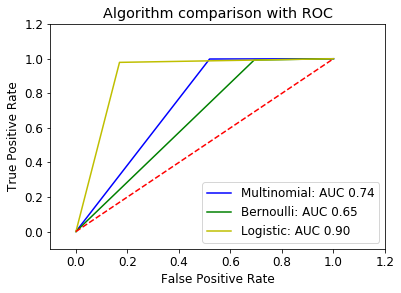

In [35]:
#To compare Multinomail Naive Bayes, Bernoulli Naive Bayes and Logistic Regression let's build a ROC curve.
#The curve which will give highest AUC value will be the best algorithm for us.

def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Algorithm comparison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.88      0.83      0.85     24762
   negative       0.97      0.98      0.97    132983

avg / total       0.95      0.96      0.96    157745



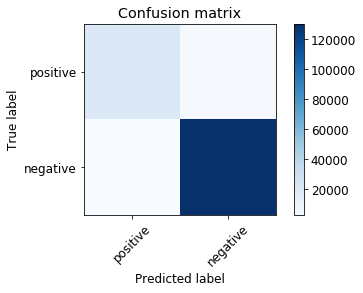

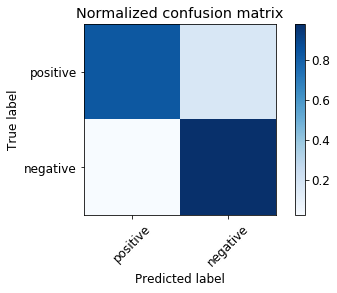

In [37]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

In [42]:
#Lets predict whether the text samples are positive or negative 

def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(logreg, "I just started using this product so I think it is too soon to rate")
test_sample(logreg, "Food was delicious but smell was awful")
test_sample(logreg, "The food was ok, I guess. The smell wasn't very good, but the taste was ok.")

Sample estimated as POSITIVE: negative prob 0.001472, positive prob 0.998528
Sample estimated as NEGATIVE: negative prob 0.998375, positive prob 0.001625
Sample estimated as NEGATIVE: negative prob 0.543000, positive prob 0.457000
